In [1]:
#Install requiered libraries
!pip install hazm
!pip install finglish
!pip install matplotlib
!pip install tensorflow_addons
!pip install gensim
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 5.4 MB/s 
     |████████████████████████████████| 1.4 MB 38.7 MB/s 
     |████████████████████████████████| 233 kB 58.8 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394487 sha256=c9c35258f1c4326aa768a46983abcc564c695de6ca9c04a93159c02e20955071
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154168 sha256=456b4912e679e3e27b11047dad3c43046d4ebe2e287206a268f110c9cc1cd62c
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Looking in indexes: https://

In [23]:
#Import requiered libraries
from hazm import *
import pandas as pd
import gensim
from gensim.models.word2vec import Word2Vec
import string
from hazm import stopwords_list
from finglish import f2p
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D, Embedding, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras import metrics, optimizers, losses
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('words')
from nltk.corpus import words
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification
import datasets
from keras import backend as K

#Defining punctuation marks, number and stop words list 
punctuationMarks = ['!','"','#','$','%','&','(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',']','^','_','{','|','}','~','؟','،','.','.','…','\\','٪']
numberList = ['۱','۲','۳','۴','۵','۶','۷','۸','۹','۰']
myStopWordsList = stopwords_list() + ['یه','چی','با','بودم']


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
#Importing out training and validation data
dfTrain = pd.read_csv('train.csv')
dfValid = pd.read_csv('dev.csv')
dfTrain

,id,comment,label,label_id
0,0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0
...,...,...,...,...
56695,56695,یک تیکه کم فرستاده بودن و با تماس من در کمترین...,HAPPY,0
56696,56696,عالی بود همه چیز ممنونم پیک هم خیلی مرتب و به ...,HAPPY,0
56697,56697,مثل همیشه عالی، من چندمین باره سفارش میدم و هر...,HAPPY,0
56698,56698,دلستر استوایی خواسته بودم اما لیمویی فرستادند,HAPPY,0


In [4]:
#Showing groups of label in training data
dfTrain.groupby('label').count()

,id,comment,label_id
label,,,
HAPPY,28350,28350,28350
SAD,28350,28350,28350


In [5]:
#Showing groups of label in validation data
dfValid.groupby('label').count()

,id,comment,label_id
label,,,
HAPPY,3150,3150,3150
SAD,3150,3150,3150


In [19]:
def textPreProcessing(df):
  #Initializing variables
  comments = []
  sents = []
  cleanSents = []
  lemmaSetFinal = []

  #Normalizing comments
  comments = [Normalizer().normalize(comment) for comment in df.comment]

  #Removeing extra spaces
  sents = [Normalizer().affix_spacing(comment) for comment in comments]

  #Converting finglish comments to farsi
  comments = []
  comments = [ f2p(comment) for comment in sents]

  #Tokenize comments
  sents = []
  sents = [word_tokenize(comment) for comment in comments]

  #Removing punctuation marks, number and stop words from tokens 
  #translator = Translator()
  for comment in sents:
      cleanSent = []
      for c in comment:
          if c not in myStopWordsList and c[0] not in punctuationMarks \
                                      and c[0] not in numberList \
                                      and len(c) > 1\
                                      and c not in cleanSent:
              cleanSent.append(c)
      cleanSents.append(cleanSent)        

  #Lemmatizing tokens
  lemmatizer = Lemmatizer()
  for token in cleanSents:
    lemmaSet = []
    for t in token:
      lemmaSet.append(lemmatizer.lemmatize(t))
    lemmaSetFinal.append(lemmaSet) 

  #Creating new column from clean data
  df['clean_comment'] = lemmaSetFinal

  return lemmaSetFinal

In [20]:
sents = textPreProcessing(dfTrain)
sentsVal = textPreProcessing(dfValid)

In [8]:
#Making a W2V model and save it
modelWo2Vec = Word2Vec(sentences=sents, vector_size=64, window=10, min_count=5, seed=42, workers=5) #vector_size=64 instead of size=64

modelWo2Vec.save('comments.w2v')

#Getting  weights and vocab and embeding size
modelWeight = modelWo2Vec.wv.vectors
vocabSize, embeddingSize = modelWeight.shape

In [11]:
#Defining prepare label function 
def prepareLabel(df):
    Y = np.asarray(df.label_id, dtype=np.int32)
    return Y

#Defining prepare data function 
def prepareData(df):
    temp = []
    X = []
    for i in df.clean_comment:
        for w in i:
            try:
                temp.append(modelWo2Vec.wv.key_to_index[w]) #modelWo2Vec.wv.key_to_index[w] instead of current code
            except KeyError:
                0
        X.append(temp)
        temp = []
    X = np.array(X, dtype=object)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0) #Adding padding
    return X

In [12]:
#Defining required variable 
MAX_SEQUENCE_LENGTH = 200 
trainX = 0
trainY = 0
validX = 0
validY = 0

#Getting training and validation data from defined function
trainX = prepareData(dfTrain)
trainY = prepareLabel(dfTrain)
validX = prepareData(dfValid)
validY = prepareLabel(dfValid)

In [13]:
#Defining recall function for binary classification
def myRecall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (all_positives + K.epsilon())
    return recall

#Defining precision function for binary classification
def myPrecision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#Defining f1_score function for binary classification
def f1_score(y_true, y_pred):
    precision = myPrecision(y_true, y_pred)
    recall = myRecall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
#Defining LSTM model
modelLSTM = Sequential()
modelLSTM.add(Embedding(input_dim=vocabSize, output_dim=embeddingSize, weights=[modelWeight], input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))
modelLSTM.add(SpatialDropout1D(0.25))
modelLSTM.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(Dense(1, activation='sigmoid'))
modelLSTM.compile(loss='binary_crossentropy',optimizer='adam', metrics=['binary_accuracy',f1_score, myPrecision, myRecall])
print(modelLSTM.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           328064    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 64)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                23000     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 351,115
Trainable params: 23,051
Non-trainable params: 328,064
_____________________________________________

In [15]:
#Fitting LSTM model
historyLSTM = modelLSTM.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=32)

Epoch 1/10
1772/1772 [==============================] - 519s 290ms/step - loss: 0.4712 - binary_accuracy: 0.7772 - f1_score: 0.7119 - myPrecision: 1.0000 - myRecall: 0.5578 - val_loss: 0.4346 - val_binary_accuracy: 0.8000 - val_f1_score: 0.7211 - val_myPrecision: 1.0000 - val_myRecall: 0.5686
Epoch 2/10
1772/1772 [==============================] - 493s 278ms/step - loss: 0.4443 - binary_accuracy: 0.7939 - f1_score: 0.7064 - myPrecision: 1.0000 - myRecall: 0.5511 - val_loss: 0.4271 - val_binary_accuracy: 0.8014 - val_f1_score: 0.7326 - val_myPrecision: 1.0000 - val_myRecall: 0.5827
Epoch 3/10
1772/1772 [==============================] - 491s 277ms/step - loss: 0.4362 - binary_accuracy: 0.7969 - f1_score: 0.7032 - myPrecision: 1.0000 - myRecall: 0.5475 - val_loss: 0.4251 - val_binary_accuracy: 0.8048 - val_f1_score: 0.7311 - val_myPrecision: 1.0000 - val_myRecall: 0.5807
Epoch 4/10
1772/1772 [==============================] - 489s 276ms/step - loss: 0.4320 - binary_accuracy: 0.8008 - f1_

In [16]:
#save LSTM model
modelLSTM.save('saved_model/modelLSTM')

INFO:tensorflow:Assets written to: saved_model/modelLSTM/assets


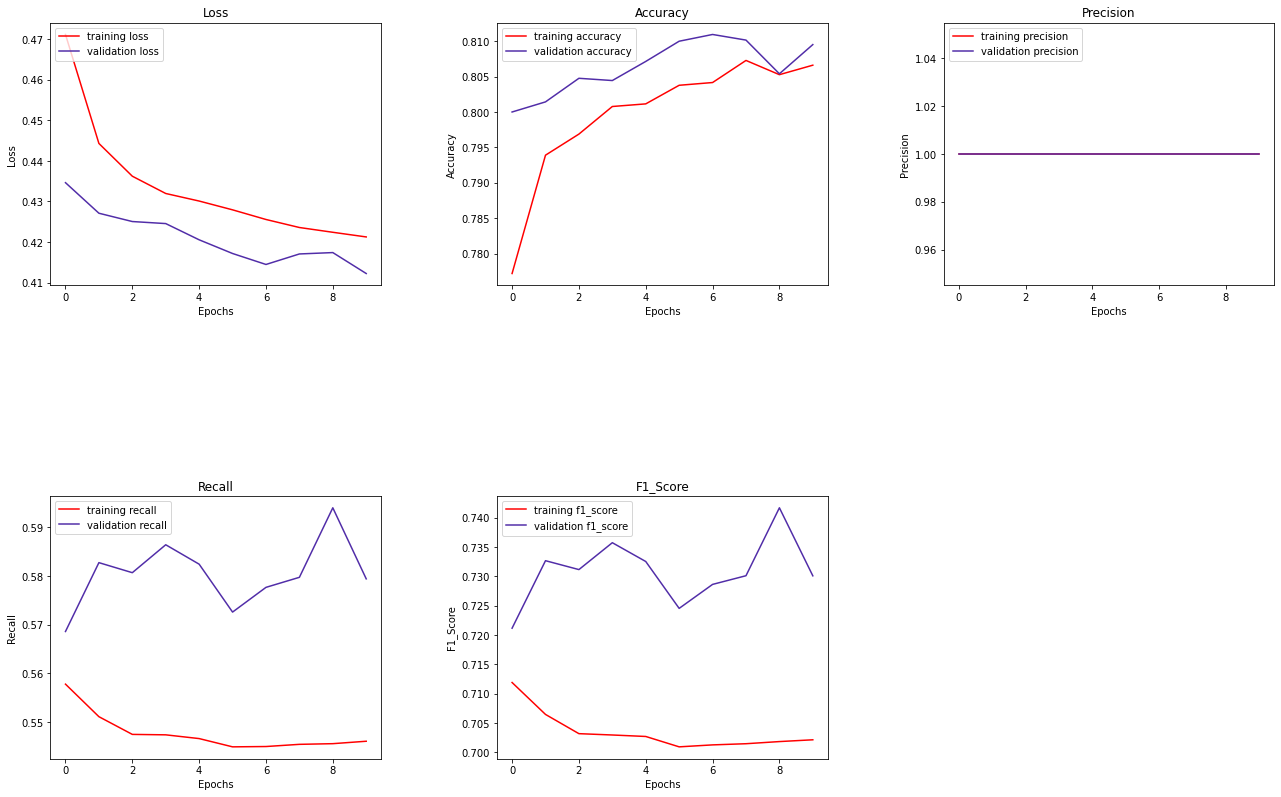

In [19]:
#Plotting measures of LSTM model
plt.figure(figsize=(20, 20))

#Loss
plt.subplot(3,3,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.plot(historyLSTM.history['loss'], color='red')
plt.plot(historyLSTM.history['val_loss'], color = '#512da8')
plt.legend(['training loss', 'validation loss'], loc='upper left')

#Accuracy
plt.subplot(3,3,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.plot(historyLSTM.history['binary_accuracy'], color='red')
plt.plot(historyLSTM.history['val_binary_accuracy'], color = '#512da8')
plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')

#Precision
plt.subplot(3,3,3)
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision')
plt.plot(historyLSTM.history['myPrecision'], color='red')
plt.plot(historyLSTM.history['val_myPrecision'], color = '#512da8')
plt.legend(['training precision', 'validation precision'], loc='upper left')

#Recall
plt.subplot(3,3,4)
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall')
plt.plot(historyLSTM.history['myRecall'], color='red')
plt.plot(historyLSTM.history['val_myRecall'], color = '#512da8')
plt.legend(['training recall', 'validation recall'], loc='upper left')

#F1_Score
plt.subplot(3,3,5)
plt.xlabel('Epochs')
plt.ylabel('F1_Score')
plt.title('F1_Score')
plt.plot(historyLSTM.history['f1_score'], color='red')
plt.plot(historyLSTM.history['val_f1_score'], color = '#512da8')
plt.legend(['training f1_score', 'validation f1_score'], loc='upper left')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.8, wspace=0.35)
plt.show()

In [20]:
#Defining CNN model
modelCNN = Sequential()
modelCNN.add(Embedding(input_dim=vocabSize, output_dim=embeddingSize, weights=[modelWeight], input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))
modelCNN.add(SpatialDropout1D(0.25))
modelCNN.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
modelCNN.add(MaxPooling1D(pool_size=2))
modelCNN.add(Flatten())
modelCNN.add(Dense(1, activation='sigmoid'))
modelCNN.compile(loss='binary_crossentropy',optimizer='adam', metrics=['binary_accuracy',f1_score, myPrecision, myRecall])
print(modelCNN.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 64)           328064    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 64)          0         
 lDropout1D)                                                     
                                                                 
 conv1d (Conv1D)             (None, 193, 32)           16416     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 96, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [22]:
#Fitting CNN model
historyCNN = modelCNN.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=32)

Epoch 1/10
1772/1772 [==============================] - 56s 31ms/step - loss: 0.4587 - binary_accuracy: 0.7810 - f1_score: 0.6761 - myPrecision: 1.0000 - myRecall: 0.5166 - val_loss: 0.4713 - val_binary_accuracy: 0.7730 - val_f1_score: 0.6895 - val_myPrecision: 1.0000 - val_myRecall: 0.5301
Epoch 2/10
1772/1772 [==============================] - 51s 29ms/step - loss: 0.4521 - binary_accuracy: 0.7852 - f1_score: 0.6719 - myPrecision: 1.0000 - myRecall: 0.5117 - val_loss: 0.4718 - val_binary_accuracy: 0.7711 - val_f1_score: 0.6966 - val_myPrecision: 1.0000 - val_myRecall: 0.5387
Epoch 3/10
1772/1772 [==============================] - 53s 30ms/step - loss: 0.4482 - binary_accuracy: 0.7878 - f1_score: 0.6735 - myPrecision: 1.0000 - myRecall: 0.5133 - val_loss: 0.4752 - val_binary_accuracy: 0.7714 - val_f1_score: 0.6669 - val_myPrecision: 1.0000 - val_myRecall: 0.5044
Epoch 4/10
1772/1772 [==============================] - 51s 29ms/step - loss: 0.4452 - binary_accuracy: 0.7882 - f1_score: 0

In [23]:
#save CNN model
modelCNN.save('saved_model/modelCNN')

INFO:tensorflow:Assets written to: saved_model/modelCNN/assets


INFO:tensorflow:Assets written to: saved_model/modelCNN/assets


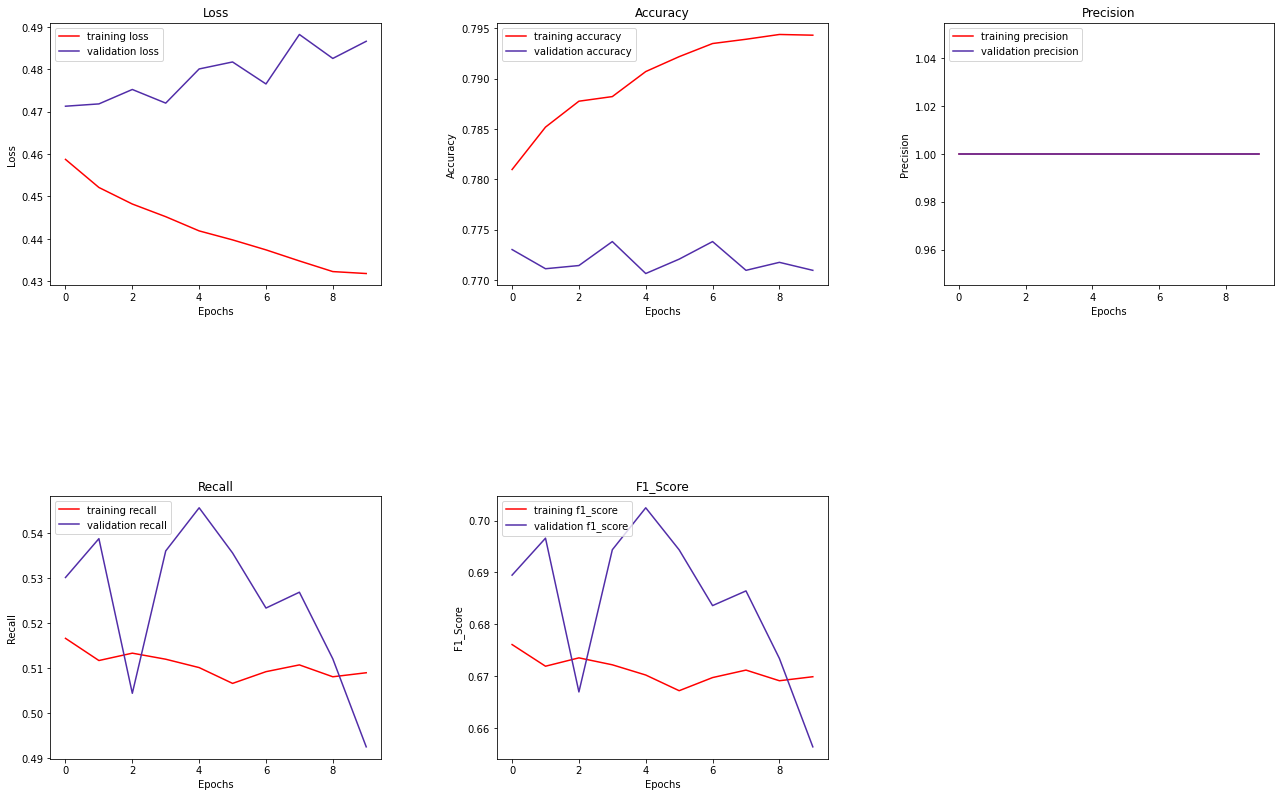

In [24]:
#Plotting measures of CNN model
plt.figure(figsize=(20, 20))

#Loss
plt.subplot(3,3,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.plot(historyCNN.history['loss'], color='red')
plt.plot(historyCNN.history['val_loss'], color = '#512da8')
plt.legend(['training loss', 'validation loss'], loc='upper left')

#Accuracy
plt.subplot(3,3,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.plot(historyCNN.history['binary_accuracy'], color='red')
plt.plot(historyCNN.history['val_binary_accuracy'], color = '#512da8')
plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')

#Precision
plt.subplot(3,3,3)
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision')
plt.plot(historyCNN.history['myPrecision'], color='red')
plt.plot(historyCNN.history['val_myPrecision'], color = '#512da8')
plt.legend(['training precision', 'validation precision'], loc='upper left')

#Recall
plt.subplot(3,3,4)
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall')
plt.plot(historyCNN.history['myRecall'], color='red')
plt.plot(historyCNN.history['val_myRecall'], color = '#512da8')
plt.legend(['training recall', 'validation recall'], loc='upper left')

#F1_Score
plt.subplot(3,3,5)
plt.xlabel('Epochs')
plt.ylabel('F1_Score')
plt.title('F1_Score')
plt.plot(historyCNN.history['f1_score'], color='red')
plt.plot(historyCNN.history['val_f1_score'], color = '#512da8')
plt.legend(['training f1_score', 'validation f1_score'], loc='upper left')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.8, wspace=0.35)
plt.show()

In [25]:
#Defining tokenize function to prepare data
def tokenizeFunc(examples):
    return tokenizer(examples['preModelData'], truncation=True)

#Defining tokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

#Preparing data
trainList = []
for i in range(len(dfTrain)):
    trainList.append(' '.join(dfTrain['clean_comment'][i]))
dfTrain['preModelData'] = np.resize(trainList, len(dfTrain))

validList = []
for i in range(len(dfValid)):
    validList.append(' '.join(dfValid['clean_comment'][i]))
dfValid['preModelData'] = np.resize(validList, len(dfValid))

#Creating dataset from clean comments and label ids
dsTrain = datasets.Dataset.from_pandas(dfTrain[['preModelData', 'label_id']])
dsValid = datasets.Dataset.from_pandas(dfValid[['preModelData', 'label_id']])

#Apply tokenize function to created dataset
trainData = dsTrain.map(tokenizeFunc, batched=True)
validData = dsValid.map(tokenizeFunc, batched=True)

#Using smaller dataset
smallTrainData = trainData.shuffle(seed=42).select(range(1000))
smallValidData = validData.shuffle(seed=42).select(range(1000))

#Defining tf as return tensors
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

#creating TensorFlow datasets from training and validation data
tfTrainData = smallTrainData.to_tf_dataset(columns=["attention_mask", "input_ids", "token_type_ids"], label_cols=['label_id'], shuffle=True, collate_fn=data_collator, batch_size=16)
tfValidData = smallValidData.to_tf_dataset(columns=["attention_mask", "input_ids", "token_type_ids"], label_cols=['label_id'], shuffle=False, collate_fn=data_collator, batch_size=16)

#Defining xlm-roberta model
modelXLM = TFAutoModelForSequenceClassification.from_pretrained('xlm-roberta-base')
modelXLM.compile(optimizer=optimizers.Adam(learning_rate=5e-5), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['binary_accuracy',f1_score, myPrecision, myRecall])

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

  0%|          | 0/57 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

Some layers of TFXLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
#Fitting xlm-roberta model
historyXLM = modelXLM.fit(x=tfTrainData, validation_data=tfValidData, epochs=10)

Epoch 1/10
63/63 [==============================] - 857s 13s/step - loss: 0.6946 - binary_accuracy: 0.4860 - f1_score: 0.0257 - myPrecision: 0.1905 - myRecall: 0.0139 - val_loss: 0.6819 - val_binary_accuracy: 0.4790 - val_f1_score: 0.0037 - val_myPrecision: 0.0317 - val_myRecall: 0.0020
Epoch 2/10
63/63 [==============================] - 829s 13s/step - loss: 0.6980 - binary_accuracy: 0.4900 - f1_score: 0.0680 - myPrecision: 0.3175 - myRecall: 0.0397 - val_loss: 0.6808 - val_binary_accuracy: 0.4800 - val_f1_score: 0.0000e+00 - val_myPrecision: 0.0000e+00 - val_myRecall: 0.0000e+00
Epoch 3/10
63/63 [==============================] - 814s 13s/step - loss: 0.6865 - binary_accuracy: 0.4915 - f1_score: 0.0597 - myPrecision: 0.3175 - myRecall: 0.0337 - val_loss: 0.7016 - val_binary_accuracy: 0.4800 - val_f1_score: 0.0000e+00 - val_myPrecision: 0.0000e+00 - val_myRecall: 0.0000e+00
Epoch 4/10
63/63 [==============================] - 826s 13s/step - loss: 0.6902 - binary_accuracy: 0.4910 - f1_

In [27]:
#save xlm-roberta model
modelXLM.save('saved_model/modelXLM')

INFO:tensorflow:Assets written to: saved_model/modelXLM/assets


INFO:tensorflow:Assets written to: saved_model/modelXLM/assets


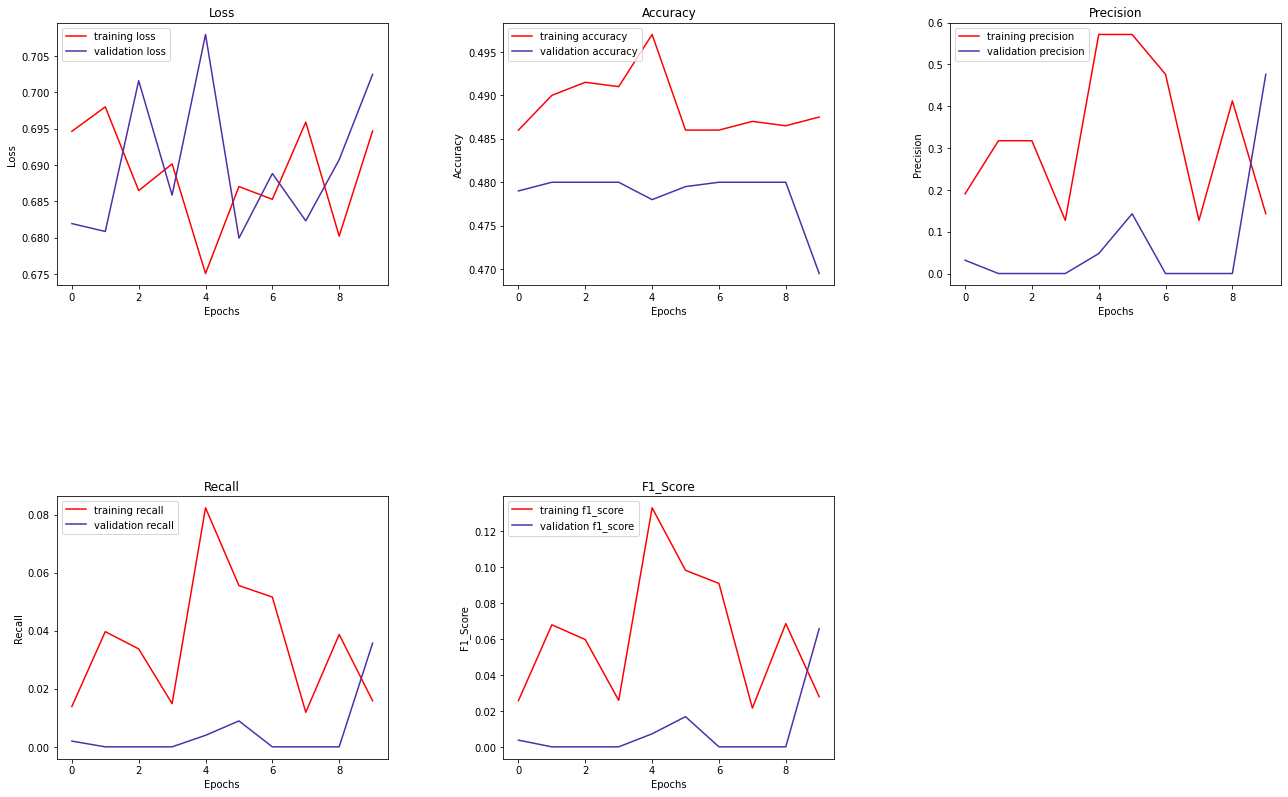

In [28]:
#Plotting measures of CNN model
plt.figure(figsize=(20, 20))

#Loss
plt.subplot(3,3,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.plot(historyXLM.history['loss'], color='red')
plt.plot(historyXLM.history['val_loss'], color = '#512da8')
plt.legend(['training loss', 'validation loss'], loc='upper left')

#Accuracy
plt.subplot(3,3,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.plot(historyXLM.history['binary_accuracy'], color='red')
plt.plot(historyXLM.history['val_binary_accuracy'], color = '#512da8')
plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')

#Precision
plt.subplot(3,3,3)
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision')
plt.plot(historyXLM.history['myPrecision'], color='red')
plt.plot(historyXLM.history['val_myPrecision'], color = '#512da8')
plt.legend(['training precision', 'validation precision'], loc='upper left')

#Recall
plt.subplot(3,3,4)
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall')
plt.plot(historyXLM.history['myRecall'], color='red')
plt.plot(historyXLM.history['val_myRecall'], color = '#512da8')
plt.legend(['training recall', 'validation recall'], loc='upper left')

#F1_Score
plt.subplot(3,3,5)
plt.xlabel('Epochs')
plt.ylabel('F1_Score')
plt.title('F1_Score')
plt.plot(historyXLM.history['f1_score'], color='red')
plt.plot(historyXLM.history['val_f1_score'], color = '#512da8')
plt.legend(['training f1_score', 'validation f1_score'], loc='upper left')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.8, wspace=0.35)
plt.show()

In [44]:
#Defining LSTM model
modelLSTM = Sequential()
modelLSTM.add(Embedding(input_dim=vocabSize, output_dim=embeddingSize, weights=[modelWeight], input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))
modelLSTM.add(SpatialDropout1D(0.25))
modelLSTM.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(Dense(1, activation='sigmoid'))
modelLSTM.compile(loss='binary_crossentropy',optimizer='adam', metrics=['binary_accuracy',f1_score, myPrecision, myRecall])

#Fitting LSTM model
historyLSTM = modelLSTM.fit(trainX, trainY, validation_data=(validX, validY), epochs=7, batch_size=32)

#save LSTM model
modelLSTM.save('saved_model/modelLSTMBest')

Epoch 1/7
1772/1772 [==============================] - 186s 103ms/step - loss: 0.4779 - binary_accuracy: 0.7720 - f1_score: 0.7152 - myPrecision: 1.0000 - myRecall: 0.5620 - val_loss: 0.4283 - val_binary_accuracy: 0.8022 - val_f1_score: 0.7277 - val_myPrecision: 1.0000 - val_myRecall: 0.5762
Epoch 2/7
1772/1772 [==============================] - 188s 106ms/step - loss: 0.4473 - binary_accuracy: 0.7897 - f1_score: 0.7060 - myPrecision: 1.0000 - myRecall: 0.5508 - val_loss: 0.4239 - val_binary_accuracy: 0.8044 - val_f1_score: 0.7325 - val_myPrecision: 1.0000 - val_myRecall: 0.5822
Epoch 3/7
1772/1772 [==============================] - 178s 100ms/step - loss: 0.4401 - binary_accuracy: 0.7948 - f1_score: 0.7046 - myPrecision: 1.0000 - myRecall: 0.5491 - val_loss: 0.4206 - val_binary_accuracy: 0.8086 - val_f1_score: 0.7281 - val_myPrecision: 1.0000 - val_myRecall: 0.5768
Epoch 4/7
1772/1772 [==============================] - 177s 100ms/step - loss: 0.4358 - binary_accuracy: 0.7972 - f1_scor

In [45]:
#Testing best model
#Importing test data
dfTest = pd.read_csv('dev.csv')

sen = textPreProcessing(dfTest)

#Preparing test data
testX = prepareData(dfTest)
testY = prepareLabel(dfTest)

#Loading each best and evaluating it
modelLSTMBest = load_model('saved_model/modelLSTMBest', custom_objects={'f1_score':f1_score,  'myPrecision':myPrecision, 'myRecall': myRecall})
loss, acc, f1, pre, rec = modelLSTMBest.evaluate(testX, testY, verbose=2)

print('Loss:', loss)
print('Accuracy:', acc)
print('F1:', f1)
print('Precision:', pre)
print('Recall:', rec)
#print(new_model.predict(test_images).shape)

197/197 - 3s - loss: 0.4146 - binary_accuracy: 0.8094 - f1_score: 0.7304 - myPrecision: 1.0000 - myRecall: 0.5802 - 3s/epoch - 16ms/step
Loss: 0.4145568907260895
Accuracy: 0.8093650937080383
F1: 0.7304475903511047
Precision: 1.0
Recall: 0.5801985263824463
